# **IRB Retail Mortgage**
# **Feature Engineering**

In this notebook, we move from **exploratory analysis** to **feature engineering**, which is a core step in retail PD model development.

Based on the outcomes of the previous notebook [`01_data_preparation_and_eda.ipynb`](../notebooks/01_data_preparation_and_eda.ipynb), we have finalised the modelling base table, defined the target variable (`default_flag`), documented variable-level treatment strategies. The focus of this notebook is:

1. Variable categorisation (numeric, categorical, count)
2. Coarse classing and binning strategy
3. WOE calculation
4. Information Value (IV) analysis
5. Variable screening and shortlist creation

Model estimation and validation are handled in subsequent notebooks.

## **Loading the Dataset**

In [1]:
# importing the required modules
import sys
sys.path.append("..")

from src.config import *
from src.utility_functions import *

In [2]:
# loading the dataset after EDA and preliminary variable strategy decisions
model_df = save_as_pickle_if_not_exists_and_load(pickle_file_path = f"{main_dir}/data/processed/mortgage_model_data.pkl")
model_df.head(5)

Pickle file already exists at: /Users/sharmadipanshu/Developer/KPMG/irb_retail_pd_sas_vs_python//data/processed/mortgage_model_data.pkl
(2260668, 22)


,id,term,loan_amnt,int_rate,installment,grade,sub_grade,purpose,verification_status,annual_inc,emp_length,home_ownership,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,t0,default_flag
0,68407277,36 months,3600.0000,13.9900,123.0300,C,C4,debt_consolidation,Not Verified,55000.0000,10+ years,MORTGAGE,5.9100,0.0000,1.0000,7.0000,0.0000,2765.0000,29.7000,13.0000,2015-12-31,0
1,68355089,36 months,24700.0000,11.9900,820.2800,C,C1,small_business,Not Verified,65000.0000,10+ years,MORTGAGE,16.0600,1.0000,4.0000,22.0000,0.0000,21470.0000,19.2000,38.0000,2015-12-31,0
2,68341763,60 months,20000.0000,10.7800,432.6600,B,B4,home_improvement,Not Verified,63000.0000,10+ years,MORTGAGE,10.7800,0.0000,0.0000,6.0000,0.0000,7869.0000,56.2000,18.0000,2015-12-31,0
3,66310712,60 months,35000.0000,14.8500,829.9000,C,C5,debt_consolidation,Source Verified,110000.0000,10+ years,MORTGAGE,17.0600,0.0000,0.0000,13.0000,0.0000,7802.0000,11.6000,17.0000,2015-12-31,0
4,68476807,60 months,10400.0000,22.4500,289.9100,F,F1,major_purchase,Source Verified,104433.0000,3 years,MORTGAGE,25.3700,1.0000,3.0000,12.0000,0.0000,21929.0000,64.5000,35.0000,2015-12-31,0


In [3]:
# categorisation of variables into identification and reference variables, numerical variables, and categorical variables

# identification and reference variables
id_cols = ['id', 't0']

# target variable
target_var = 'default_flag'

# numerical continuous variables 
num_continuous_vars = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_bal', 'revol_util']

# numerical count variables 
num_count_vars = ['delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc']

# categorical variables 
categorical_vars = ['term' , 'grade', 'sub_grade', 'purpose', 'verification_status', 'home_ownership', 'emp_length']

# checking the columns which are not present in the above deined lists 
undefined_vars = [col for col in model_df.columns.tolist() if col not in [target_var] + num_continuous_vars + num_count_vars + categorical_vars + id_cols]
print(f"Undefined Variables: {undefined_vars}")
    

Undefined Variables: []


## **Binning Strategy and Coarse Classing**

In retail PD modelling, raw variables are rarely used directly due to skewness, outliers, and unstable risk patterns at extreme values. Instead, variables are transformed into ordered risk buckets using coarse classing and monotonic binning.

The binning strategy in this notebook follows these principles:
- Preserve economic intuition and monotonic risk ordering
- Use coarse, interpretable bins rather than overly granular splits
- Ensure sufficient observations in each bin
- Handle outliers through capping rather than deletion

All binning decisions are data-driven but constrained by credit risk logic. For numeric continuous variables, monotonic binning is performed using isotonic regression to smooth noisy default-rate patterns while preserving economic intuition. For numeric count variables and categorical, manual coarse classing is preferred due to sparsity and zero inflation, which can lead to unstable isotonic fits.

- The Ordinal categorical variables requires perfect monotonicity after clubbing. Such variables are `term`, `grade`, and `sub_grade`.
- There are few semi-ordinal variables, they require directional monotonicity not strict. Such variables are `emp_length` and `home_ownership`. 
- The Nominal Categorical vaiables are `purpose`, `verification_status`. Monotonicity is not conceptually required for these variables. 

In [4]:
# checking missing value percentages across variables
missing_pct = model_df.isna().mean().sort_values(ascending=False)

print("\nVariables with missing values:")
for col, pct in missing_pct[missing_pct > 0].items():
    print(f"  {col}: {pct:.5%} missing")


Variables with missing values:
  emp_length: 6.49839% missing
  revol_util: 0.07971% missing
  dti: 0.07569% missing
  inq_last_6mths: 0.00133% missing
  total_acc: 0.00128% missing
  pub_rec: 0.00128% missing
  open_acc: 0.00128% missing
  delinq_2yrs: 0.00128% missing
  annual_inc: 0.00018% missing


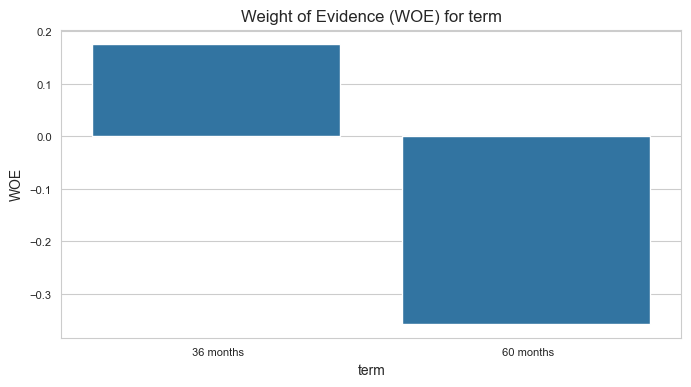

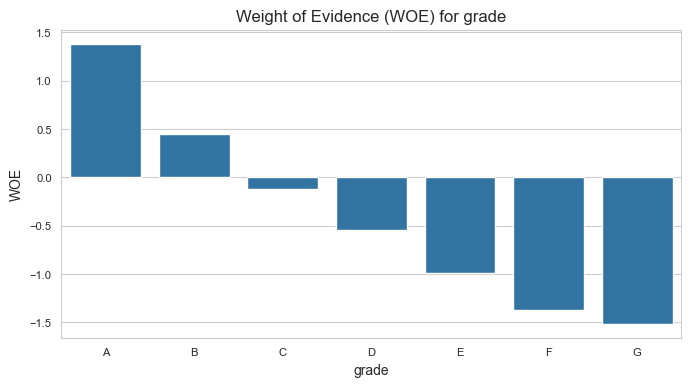

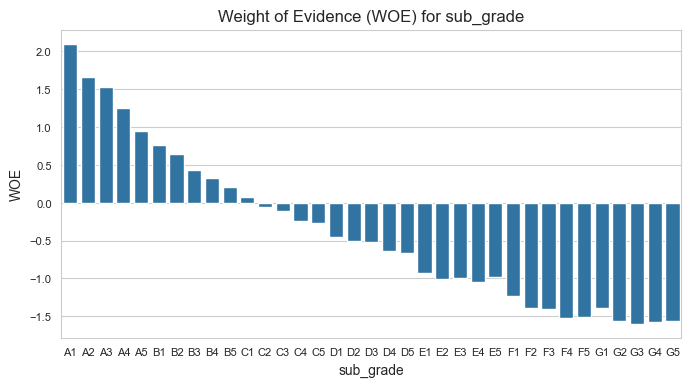

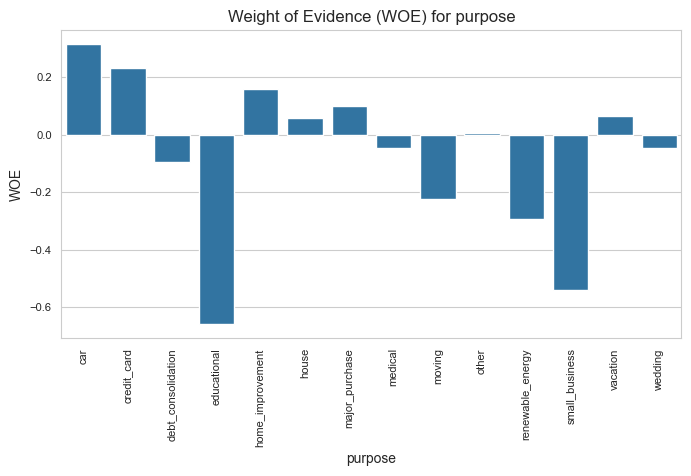

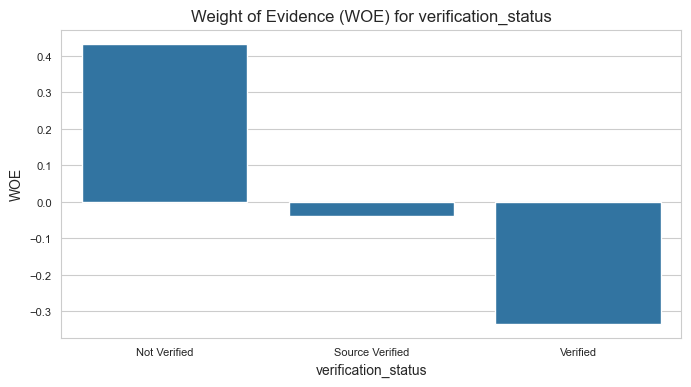

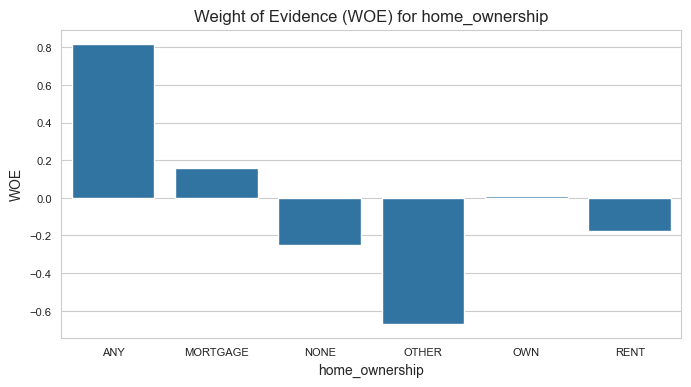

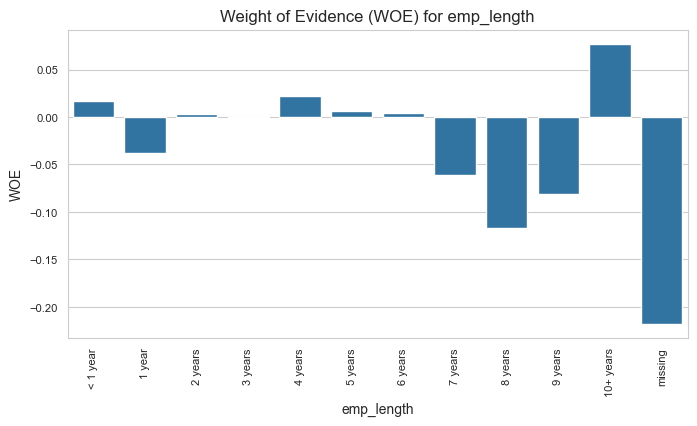

In [6]:
categorical_var_results = {}

# calculating WOE for categorical variables
for var in categorical_vars:
    woe = WOE(model_df, feature=var, target=target_var)
    if var == 'emp_length':
        emp_length_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years', 'missing']
        woe.set_index(var, inplace=True)
        woe = woe.reindex(emp_length_order).reset_index()

    if var in ['purpose', 'emp_length']:
        rotation_angle = 90
    else:
        rotation_angle = 0
        
    # plotting WOE values
    fig = plt.figure(figsize=(8, 4))
    sns.barplot(x=var, y='woe', data=woe)
    plt.title(f'Weight of Evidence (WOE) for {var}')
    plt.xlabel(var)
    plt.ylabel('WOE')
    plt.xticks(rotation=rotation_angle)
    # setting font size for x and y ticks
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    fig.show()

    categorical_var_results[var] = {'woe_summary' : woe, 'woe_plot': fig}

- The loan term variable exhibits clear and monotonic risk differentiation, with 60-month loans showing materially higher default risk than 36-month loans. The variable is retained without further grouping.

- grade/Sub-grade provides additional risk differentiation beyond grade; however, raw sub-grades exhibit local non-monotonicity in higher risk bands due to sparsity. Sub-grades are therefore coarsely grouped within grades to restore monotonic risk ordering (E1, E23, E45, F1, F2, F3, F45, G12345). As Grade and Subgrade are highly correlated, grade can be dropped for future analysis. 

- Purpose: Low Risk - [car, credit_card, home improvement], Medium Risk - [debt consolidation, house, wedding], High Risk - [small business, educational, renewable energy], remaining as per conservative behaviour we can assign to high risk.

- Verification status exhibits monotonic WOE behavior, with higher observed risk for verified loans due to risk selection effects. The variable is retained without reordering.

- Home ownership exhibits economically intuitive risk ordering after grouping rare categories. Ownership and mortgage status are associated with lower risk, while renting and non-ownership indicate higher default risk.

- Employment length shows weak and noisy risk patterns at fine granularity. The variable is therefore coarsely grouped, with missing values treated as a separate high-risk category.



In [13]:
model_df["clubbed_term"] = model_df["term"]

sub_grade_mapping = {'E2': 'E23', 'E3': 'E23', 'E4': 'E45', 'E5': 'E45', 'F4' : 'F45', 'F5' : 'F45'}

model_df['clubbed_sub_grade'] = np.where(model_df.sub_grade.isin(sub_grade_mapping.keys()), model_df.sub_grade.map(sub_grade_mapping), 
                                         np.where(model_df.sub_grade.str.contains('G'), 'G', model_df.sub_grade))

model_df['clubbed_purpose'] = np.where(model_df.purpose.isin(['car', 'credit_card', 'home_improvement']), '0. low_risk', 
                                       np.where(model_df.purpose.isin(['debt_consolidation', 'house', 'wedding']), '1. medium_risk', '2. high_risk'))

model_df['clubbed_verification_status'] = model_df['verification_status']
model_df['clubbed_home_ownership'] = np.where(model_df.home_ownership.isin(['OWN', 'MORTGAGE']), '0. owned', 
                                              np.where(model_df.home_ownership.isin(['RENT']), '1. rent', '2. other'))

model_df['clubbed_emp_length'] = np.where(model_df['emp_length'].isin(["< 1 year", "1 year"]), "0. <2_YEARS",
                                            np.where(model_df['emp_length'].isin(["2 years", "3 years", "4 years", "5 years"]), "1. 2_5_YEARS",
                                            np.where(model_df['emp_length'].isin(["6 years", "7 years", "8 years", "9 years"]), "2. 6_9_YEARS",
                                            np.where(model_df['emp_length'] == "10+ years", "3. 10+_YEARS", "unknown"
                                            ))))

clubbed_categorical_vars = ['clubbed_term', 'clubbed_sub_grade', 'clubbed_purpose', 'clubbed_verification_status', 'clubbed_home_ownership', 'clubbed_emp_length']

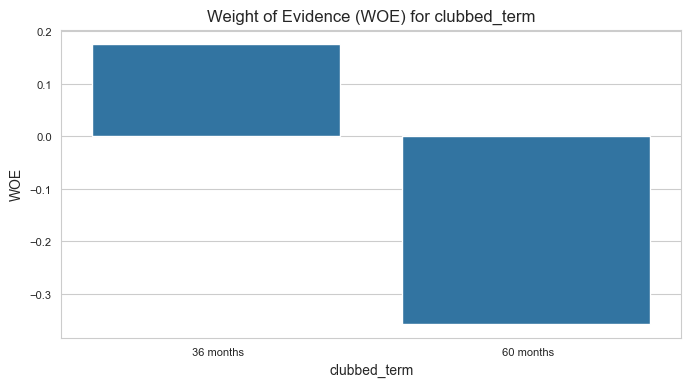

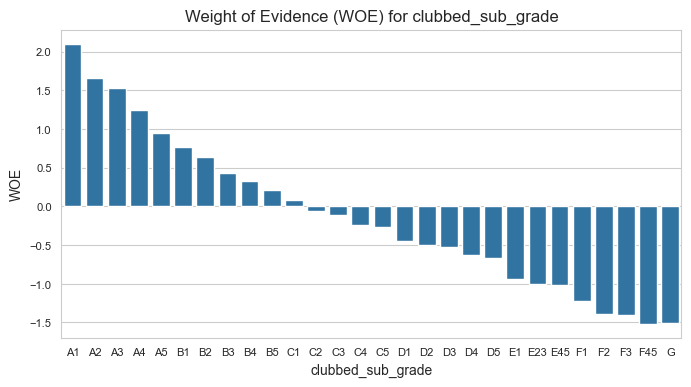

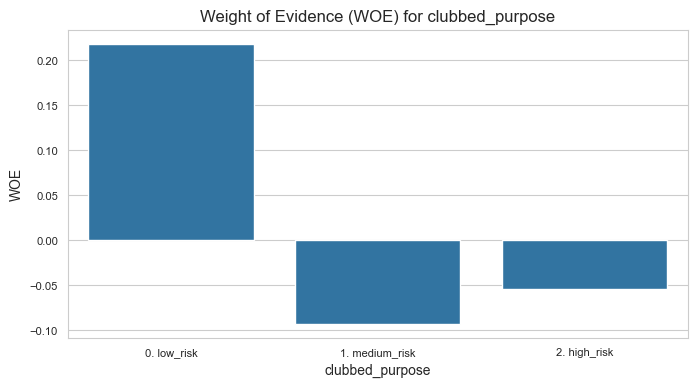

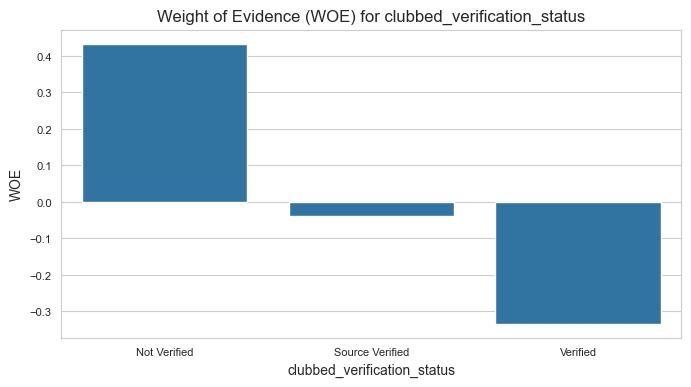

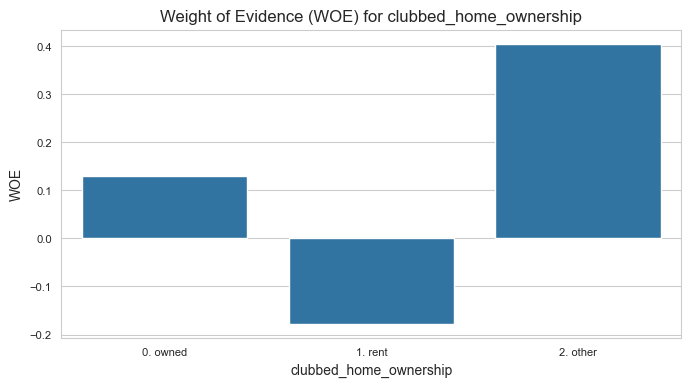

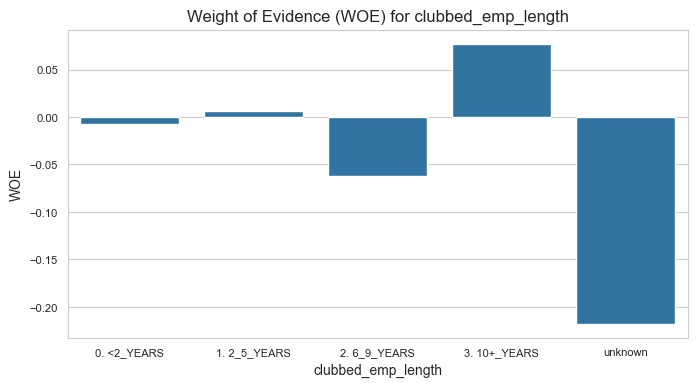

In [14]:
clubbed_categorical_var_results = {}

# calculating WOE for categorical variables
for var in clubbed_categorical_vars:
    woe = WOE(model_df, feature=var, target=target_var)
    if var == 'emp_length':
        emp_length_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years', 'missing']
        woe.set_index(var, inplace=True)
        woe = woe.reindex(emp_length_order).reset_index()

    if var in ['purpose', 'emp_length']:
        rotation_angle = 90
    else:
        rotation_angle = 0
        
    # plotting WOE values
    fig = plt.figure(figsize=(8, 4))
    sns.barplot(x=var, y='woe', data=woe)
    plt.title(f'Weight of Evidence (WOE) for {var}')
    plt.xlabel(var)
    plt.ylabel('WOE')
    plt.xticks(rotation=rotation_angle)
    # setting font size for x and y ticks
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    fig.show()

    clubbed_categorical_var_results[var] = {'woe_summary' : woe, 'woe_plot': fig}

## **Output**

In [ ]:
# exporting the categorical woe results to a excel file
with pd.ExcelWriter(f"{main_dir}/summaries_and_charts/woe_categorical_vars.xlsx", engine='xlsxwriter') as writer:
        for sheet_name, df in categorical_var_results.items():
            df['woe_summary'].to_excel(writer, sheet_name=sheet_name, index=False)
            df['woe_plot'].savefig(f"{main_dir}/summaries_and_charts/woe_{sheet_name}.png")

# exporting the clubbed categorical woe result to a excel file
with pd.ExcelWriter(f"{main_dir}/summaries_and_charts/clubbed_woe_categorical_vars.xlsx", engine='xlsxwriter') as writer:
        for sheet_name, df in clubbed_categorical_var_results.items():
            df['woe_summary'].to_excel(writer, sheet_name=sheet_name, index=False)
            df['woe_plot'].savefig(f"{main_dir}/summaries_and_charts/woe_{sheet_name}.png")